# Стратегия удержания клиентов в сети фитнес-центров

<p>Необходимо на основании имеющихся данных о пользователях фитнес-центра построить модель прогнозирования оттока клиентов</p>

<b>Задачи:</b>
<ol><li>научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;</li>
<li>сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;</li>
<li>проанализировать основные признаки, наиболее сильно влияющие на отток;</li>
<li>сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:</li>
<ul><li>выделить целевые группы клиентов;</li>
<li>предложить меры по снижению оттока;</li>
<li>определить другие особенности взаимодействия с клиентами.</li></ul></ol>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Шаг-1.-Загрузка-данных" data-toc-modified-id="Шаг-1.-Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Шаг 1. Загрузка данных</a></span></li><li><span><a href="#Шаг-2.-Исследовательский-анализ-данных-(EDA)" data-toc-modified-id="Шаг-2.-Исследовательский-анализ-данных-(EDA)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Шаг 2. Исследовательский анализ данных (EDA)</a></span></li><li><span><a href="#Шаг-3.-Построение-модели-прогнозирования-оттока-клиентов" data-toc-modified-id="Шаг-3.-Построение-модели-прогнозирования-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Шаг 3. Построение модели прогнозирования оттока клиентов</a></span></li><li><span><a href="#Шаг-4.-Кластеризация-клиентов" data-toc-modified-id="Шаг-4.-Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Шаг 4. Кластеризация клиентов</a></span></li><li><span><a href="#Шаг-5.-Выводы-и-базовые-рекомендации-по-работе-с-клиентами" data-toc-modified-id="Шаг-5.-Выводы-и-базовые-рекомендации-по-работе-с-клиентами-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Шаг 5. Выводы и базовые рекомендации по работе с клиентами</a></span></li></ul></div>

### Шаг 1. Загрузка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [2]:
# загрузим датасет и посмотри на первые 10 строк таблицы
df = pd.read_csv('/datasets/gym_churn.csv')
df.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


`Churn` — факт оттока в текущем месяце

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

<b>Вывод</b>

Мы импортировали все необходимые для работы библиотеки, загрузили файл с данными и вывели первые 10 строк таблицы. В таблице преставлены данные на месяц до оттока и факт оттока на определённый месяц. Как видим, признаки, которые характеризуют пользователей фитнес-центра, представлены как в виде числовых переменных (`Age`, `Lifetime`, `Contract_period`, `Month_to_end_contract`, `Avg_class_frequency_total`, `Avg_class_frequency_current_month`, `Avg_additional_charges_total`), так и в виде бинарных признаков (`gender`, `Near_Location`, `Partner`, `Promo_friends`, `Phone`, `Group_visits`). В дальнейшем необходимо учитывать эту информацию, а также провести стандартизацию данных, потому что веса для разных признаков учитывают масштаб этих признаков.

### Шаг 2. Исследовательский анализ данных (EDA)

Исследовательский анализ данных будет включать следующие шаги:
1. Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения методом describe();
2. Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался методом groupby();
3. Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
4. Построим матрицу корреляций и отобразим её.

In [3]:
# посмотрим размер датафрейма
df.shape

(4000, 14)

Всего в таблице представлены данные о 4000 тысячах пользователей по 13 признакам и факту, ушел пользователь в отток или нет.

In [4]:
# посмотрим на сводную информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В таблице нет пропущенных значений, а также тип данных по всем столбцам является корректным.

In [5]:
# посмотрим на средние значения и стандартные отклонения
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Средние показатели и стандартные отклонения говорят о том, что в данных нет аномальных выбросов, но еще дополнительно проверим это построение гистрограмм и матриц рассеяния.

In [6]:
# посмотрим наличие дубликатов в данных
df.duplicated().sum()

0

В таблице отсутствуют дубликаты данных.

In [7]:
# посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
df.groupby('Churn')['Age', 'Contract_period', 'Avg_additional_charges_total', 'Month_to_end_contract', 
                    'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month'].mean()

,Age,Contract_period,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,
0,29.976523,5.747193,158.445715,5.283089,4.711807,2.024876,2.027882
1,26.989632,1.728558,115.082899,1.662582,0.990575,1.474995,1.044546


In [8]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Средние показатели тех, кто не ушёл в отток:

- в среднем чаще проживают или работают недалеко от фитнес-центра,
- в среднем чаще приходят по акции "приведи друга",
- в среднем чаще посещают групповые занятия,
- средний возраст пользователей больше, чем тех, кто ушёл (30 и 27 соответственно),
- средний срок абонемента составляет 5,7 месяцев (для тех, кто ушёл - 1,7),
- средний срок до окончания абонемента - 5,3 (для тех, кто ушёл - 1,7)
- они больше тратят на другие услуги фитнес-центра
- они пользуеются услугами в среднем более 4,7 месяцев (те, кто ушли - около 1 месяца),
- более стабильно посещают фитнес-центр: за все время - в среднем 2 раза в неделю, за последний месяц - в среднем 2 раза в неделю (кто ушел - за все время 1,5 раз в неделю, за последний месяц - 1 раз в неделю).

In [12]:
# посмотрим на количество пользователей, которые ушли и которые не ушли в отток, представлены в таблице
df['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

Как видим, пользователи в таблице в соответствии с оттоком распределились следующим образом: 73% процента остались, 27% ушли в отток. Таким образом, можем сделать вывод, что наша целевая переменная не имеет структуру временного ряда, поэтому в дальнейшем для разделения выборки на обучающую и валидационную будем использовать функцию train_test_split().

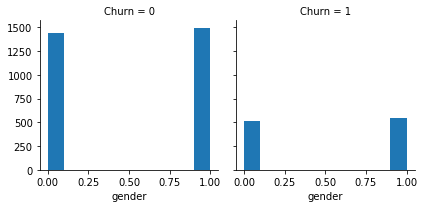

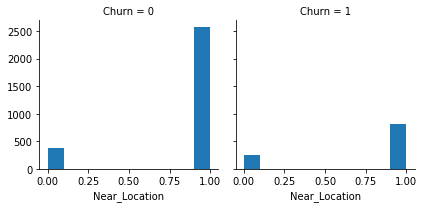

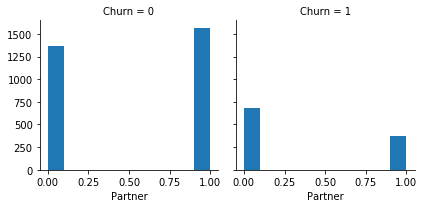

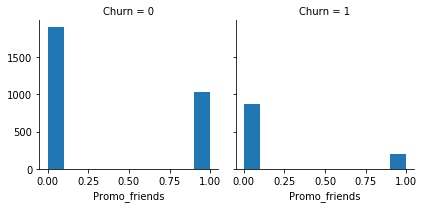

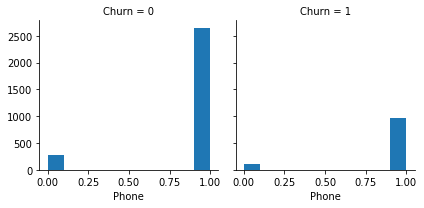

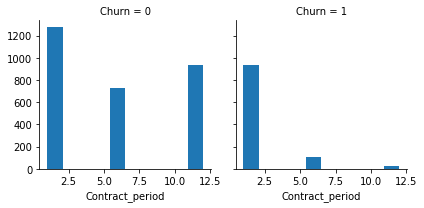

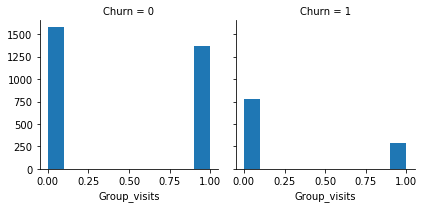

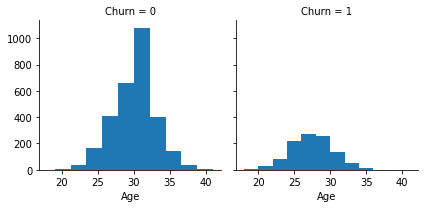

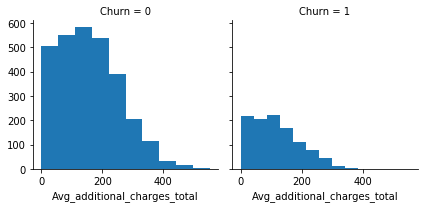

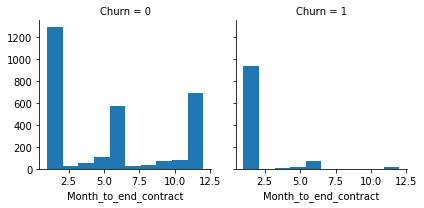

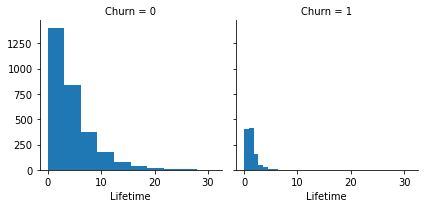

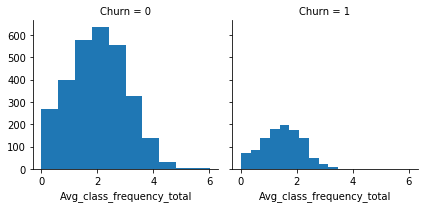

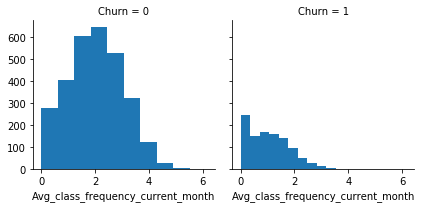

In [9]:
# построим гистограммы для тех, кто ушел (отток) и тех, кто остался (не попал в отток)
for feature in df.drop('Churn', axis=1).columns:
    g = sns.FacetGrid(df, col='Churn')
    g = g.map(plt.hist, feature)

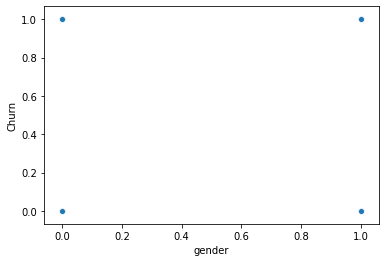

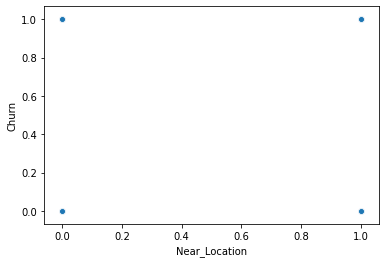

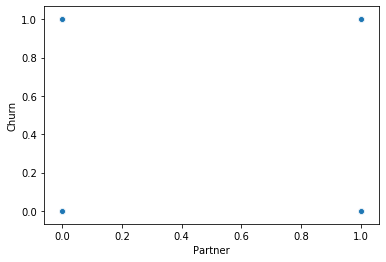

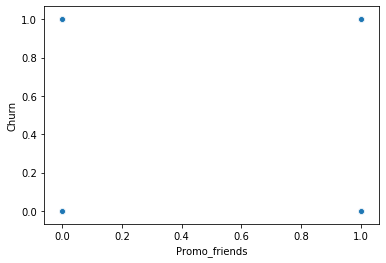

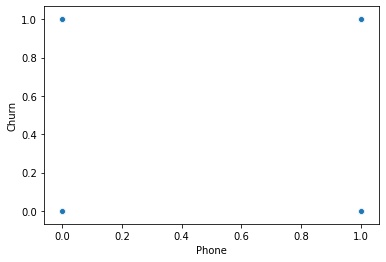

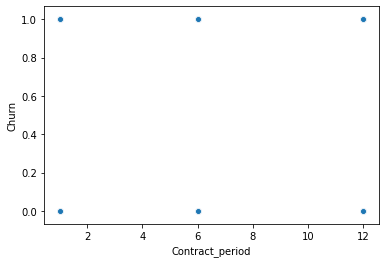

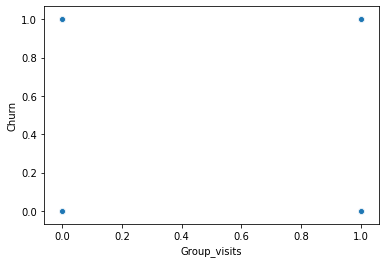

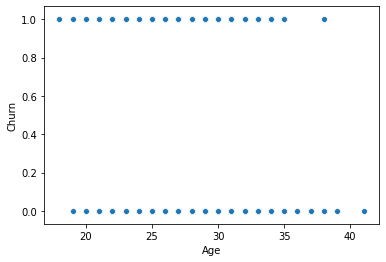

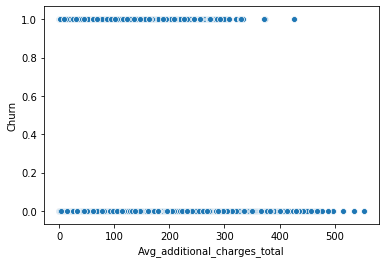

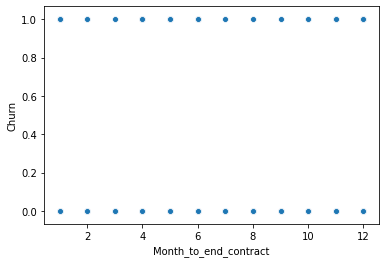

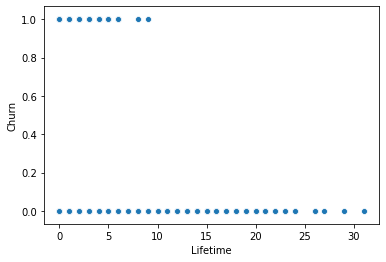

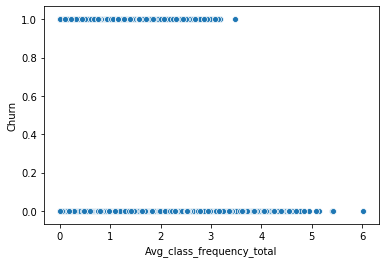

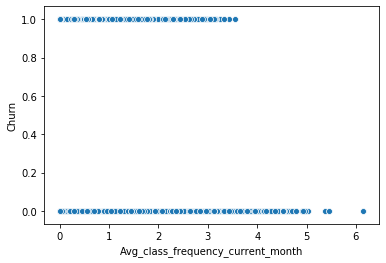

In [13]:
# построим матрицы рассеяния 
for col in df.drop('Churn', axis = 1).columns:
    sns.scatterplot(df[col], df['Churn'])
    plt.show()

Гистограммы и матрицы рассеяния подтверждают наши выводы, которые мы сделали на основании средних значений, а также демонстрируют, что в данных нет аномальных выбросов данных и в целом поведение признаков более-менее нормальное.

In [14]:
# построим матрицу корреляций
cm = df.corr()
cm

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
Contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
Group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
Age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
Avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
Month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


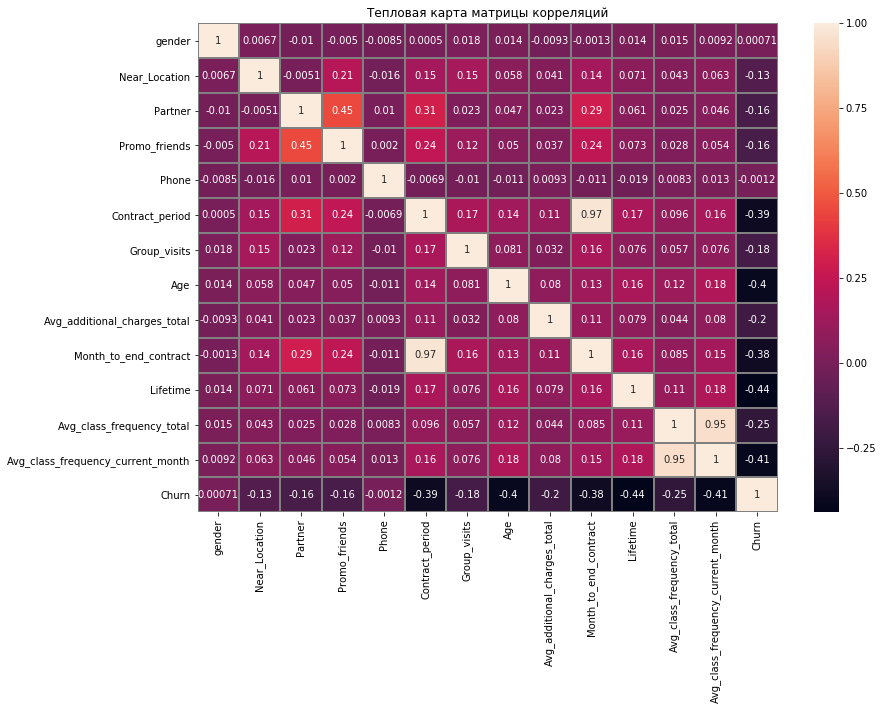

In [16]:
# нарисуем тепловую карту с подписями для матрицы корреляций
plt.figure(figsize=(13, 9))
sns.heatmap(cm, annot = True, linewidths=1, linecolor='gray')
plt.title('Тепловая карта матрицы корреляций')
plt.show()

Как видим на карте, есть две пары признаков, которые сильно коррелируют между собой: `Contract_period` - `Month_to_end_contract` (степень корреляции - 0,97) и `Avg_class_frequency_total` - `Avg_class_frequency_current_month` (0,95). Данные пары признаков сильно коррелируют между собой, потому что являются описание схожих характеристик. Касательно корреляции признаков с целевой переменной можно отметить, что практически не коррелируют `gender` и `Phone`. Также все признаки имет отрицательную корреляцию с целевой переменной - чем больше значение признака, тем реже пользователи уходях в отток. Наиболее ценными признаками являются `Contract_period`, `Age`, `Month_to_end_contract`, `Lifetime`, `Avg_class_frequency_current_month`.

<b>Вывод</b>

- В таблице имеются данные по 4000 пользователей, 13 признакам и одной целевой переменной `Churn`, которая представлена не в виде временного ряда, а категорией.
- В данных отсутствуют пропуски, дубликаты, аномальные значения.
- Две пары признаков, которые сильно коррелируют между собой: `Contract_period - Month_to_end_contract` и `Avg_class_frequency_total - Avg_class_frequency_current_month`. Мы их не удаляли, но применим L2 регуляризацию при обучении модели.
- Наиболее ценными признаками являются `Contract_period`, `Age`, `Month_to_end_contract`, `Lifetime`, `Avg_class_frequency_current_month`. Наименее ценные - `gender` и `Phone`.
- Все признаки имет отрицательную корреляцию с целевой переменной - чем больше значение признака, тем реже пользователи уходях в отток.

Средние показатели тех, кто не ушёл в отток:

- в среднем чаще проживают или работают недалеко от фитнес-центра,
- в среднем чаще приходят по акции "приведи друга",
- в среднем чаще посещают групповые занятия,
- средний возраст пользователей больше, чем тех, кто ушёл (30 и 27 соответственно),
- средний срок абонемента составляет 5,7 месяцев (для тех, кто ушёл - 1,7),
- средний срок до окончания абонемента - 5,3 (для тех, кто ушёл - 1,7)
- они больше тратят на другие услуги фитнес-центра
- они пользуеются услугами в среднем более 4,7 месяцев (те, кто ушли - около 1 месяца),
- более стабильно посещают фитнес-центр: за все время - в среднем 2 раза в неделю, за последний месяц - в среднем 2 раза в неделю (кто ушел - за все время 1,5 раз в неделю, за последний месяц - 1 раз в неделю).

### Шаг 3. Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

<ol><li>Разобьем данные на обучающую и валидационную выборку функцией train_test_split();</li>
<li>Обучим модель на train-выборке двумя способами:
<ul><li>логистической регрессией,</li>
<li>случайным лесом.</li></ul></li>
<li>Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели.</li></ol>

In [17]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [18]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('Churn', axis = 1)
y = df['Churn']

In [19]:
# разделим модель на обучающую и валидационную выборку функцией train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [21]:
# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [24]:
# зададим алгоритм для модели логистической регрессии и и учтем L2-регуляризацию (solver='lbfgs')
lr_model = LogisticRegression(solver='lbfgs')

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

# выведем все метрики
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97


In [23]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

# выведем все метрики
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97


<b>Вывод</b>

- Доля верных ответов (Accuracy) в двух моделях является одинаковой и высокой - 0,92. Это значит, что 92% предсказанных результатов являются верными.
- Precision говорит, какая доля прогнозов относительно ухода пользователя в отток верна. То есть в случае с логистической регрессией доля правильных ответов только среди целевого класса (отток) составляет 85%. В модели случайного леса эта доля ниже - 84%.
- Recall показывает, сколько реальных объектов "1" класса (отток) мы смогли обнаружить с помощью модели. Для модели логистикеской регрессии она выше, чем для модели случайного леса (83% и 81% соответственно).
- Так как precision и recall направлены на избежание противоположных рисков, то мы посчитали еще сводную метрику, учитывающую баланс между precision и recall - F1-score. Чем она ближе к 1, тем лучше. Для логистической регрессии она чуть выше, чем для модели случайного леса (84% и 83% соответственно). 
- Также для оценки качества классификатора посчитали ROC-AUC - чем ближе к 1, тем лучше. Для двух моделей эта метрика является одинаково высокой - 97%.

Таким образом, лучше всего на имеющихся данных перформит модель логистической регрессии.

### Шаг 4. Кластеризация клиентов

Отложим в сторону столбец с оттоком и проведем кластеризацию объектов (клиентов):
1. Стандартизируем данные.
2. Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.
3. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 
4. Посмотрим на средние значения признаков для кластеров.
5. Построим распределения признаков для кластеров.
6. Для каждого полученного кластера посчитаем долю оттока (методом groupby()).

In [25]:
# обязательная стандартизация данных перед работой с алгоритмом
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [26]:
# построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков
linked = linkage(X_sc, method = 'ward')

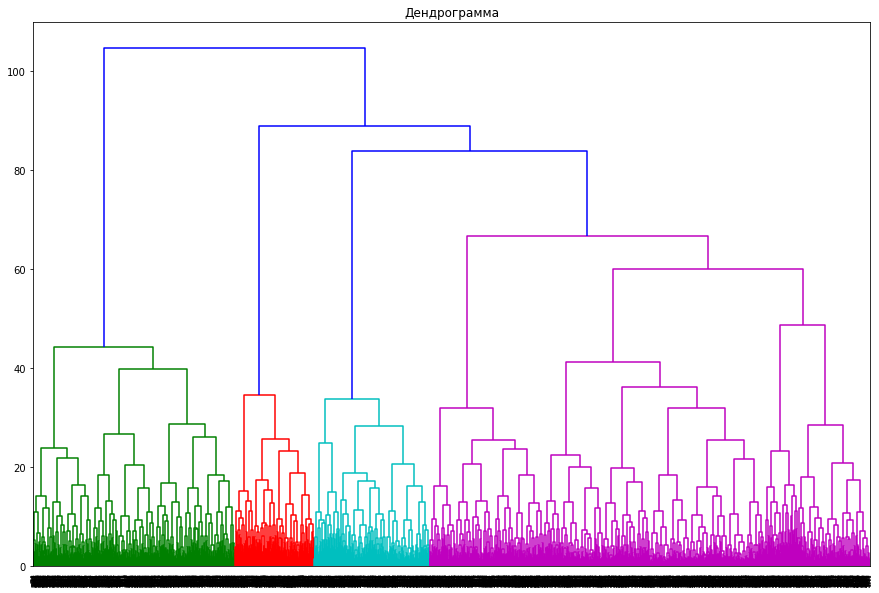

In [27]:
# нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.show()

In [28]:
# обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов
km = KMeans(n_clusters = 5, random_state = 0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc)

In [29]:
# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

In [30]:
# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster_km').agg('mean')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


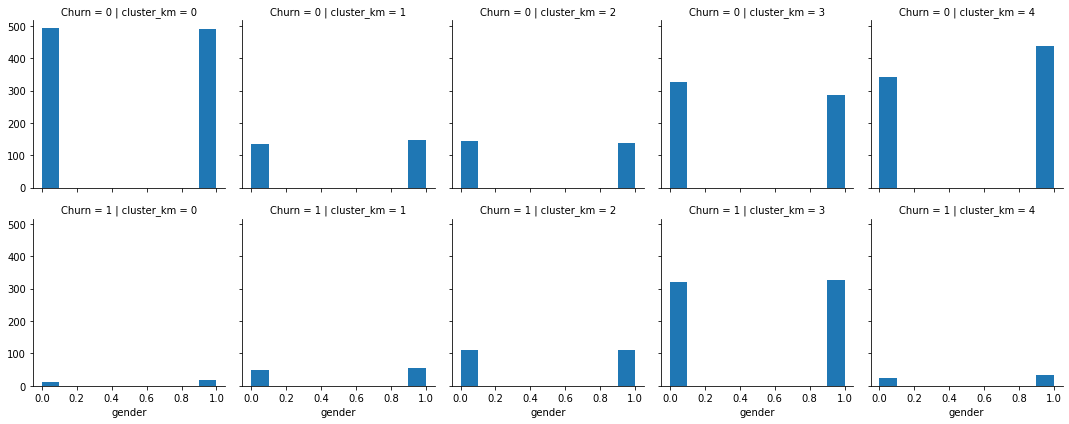

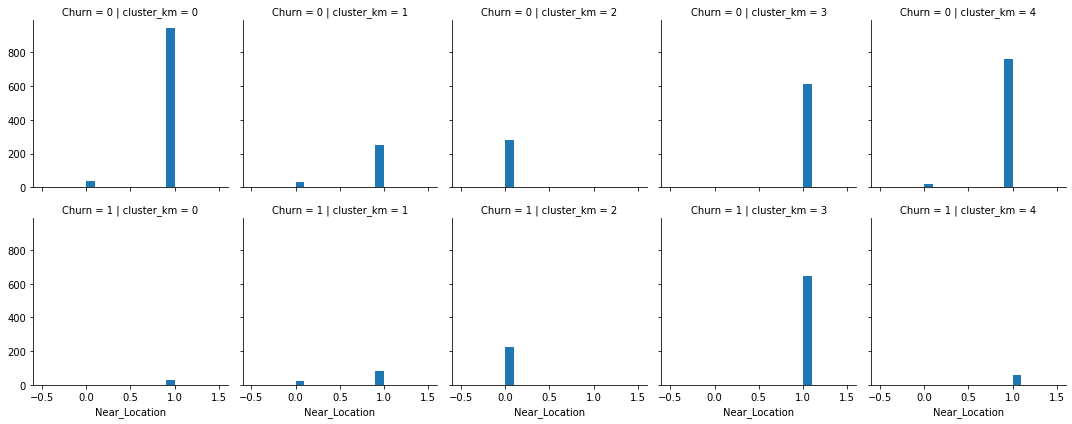

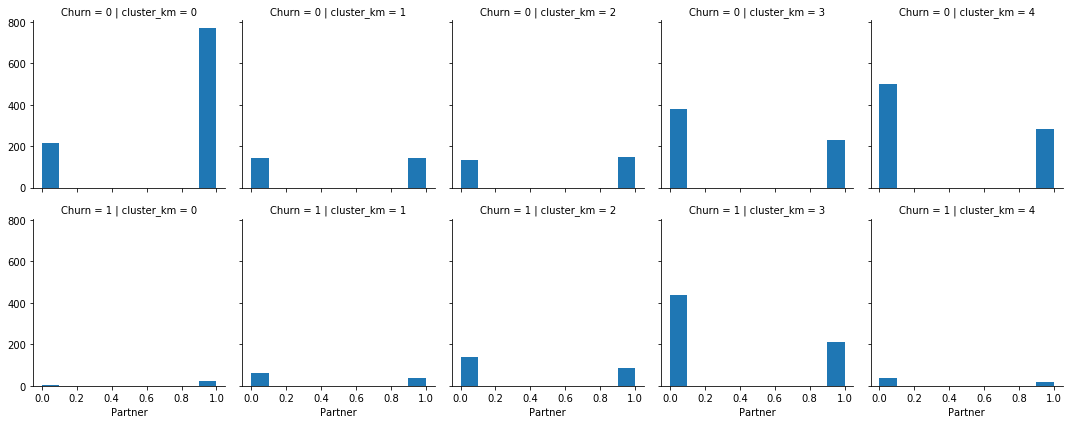

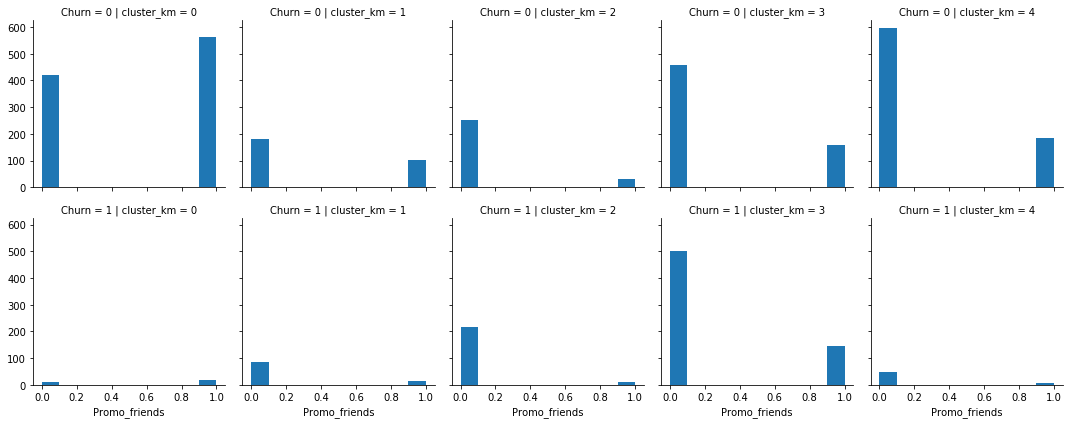

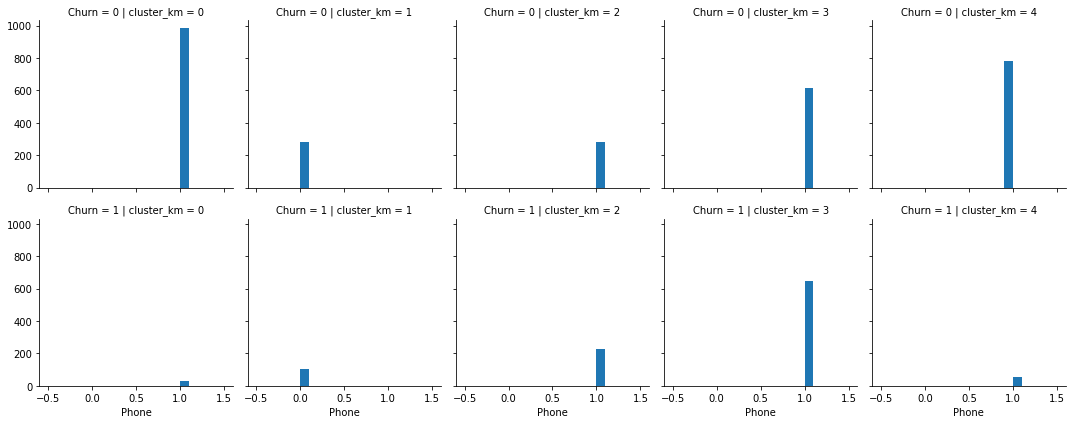

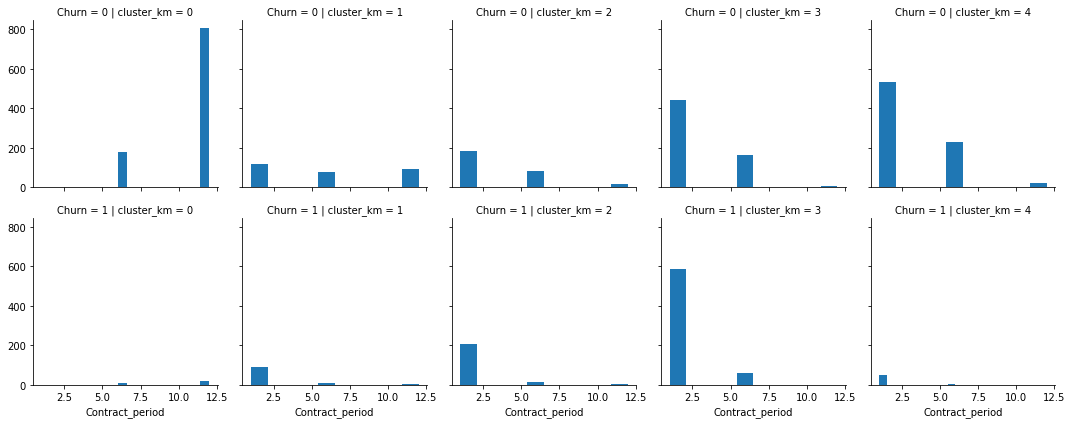

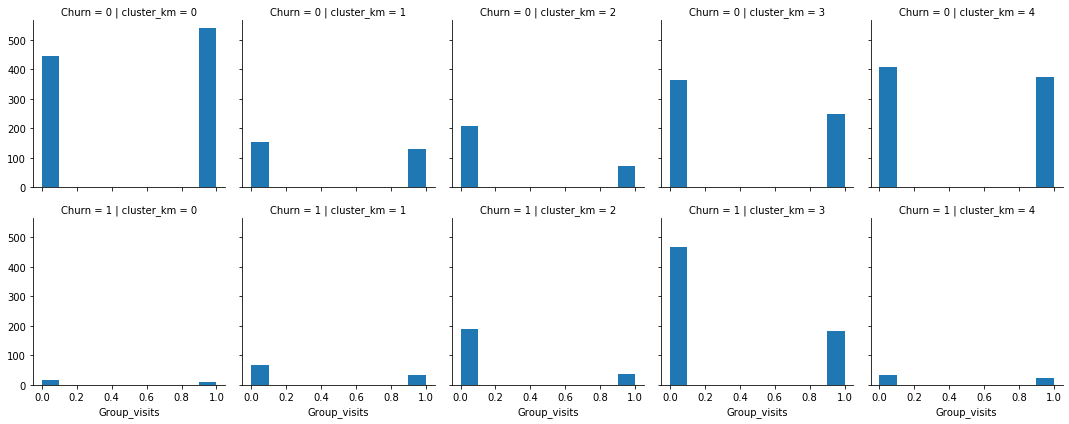

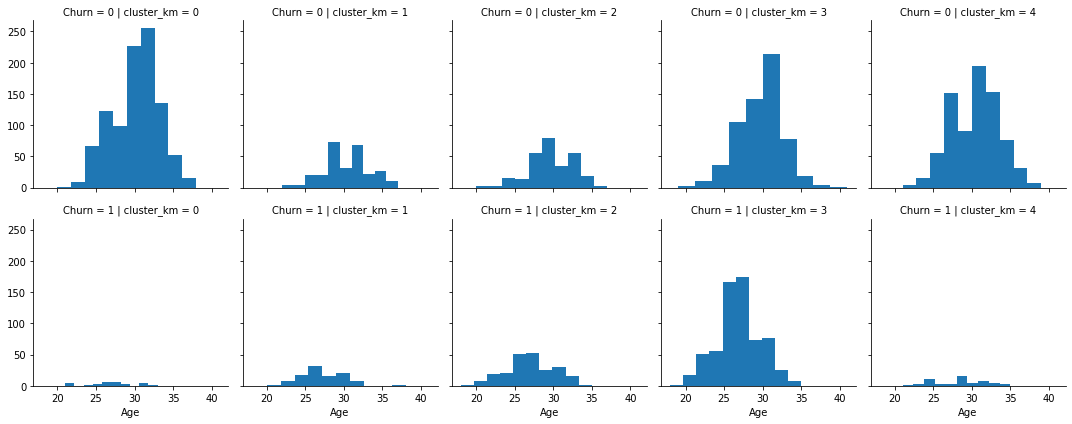

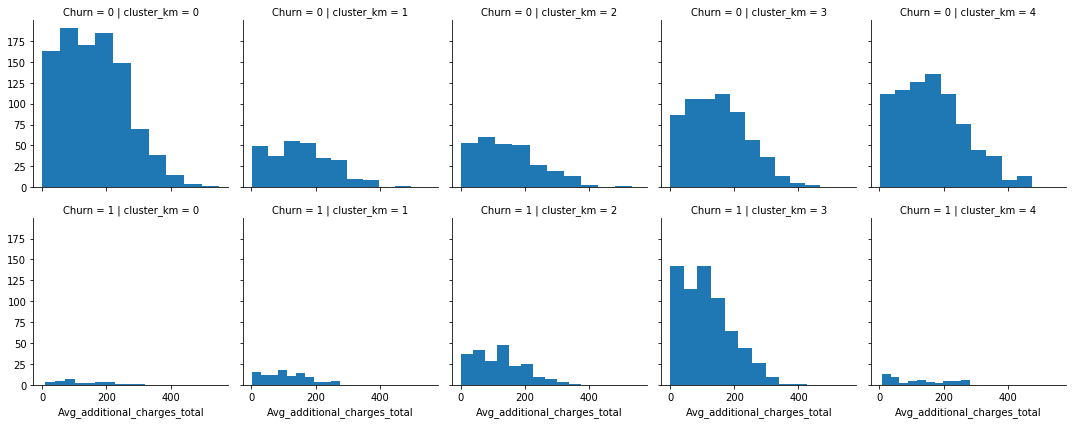

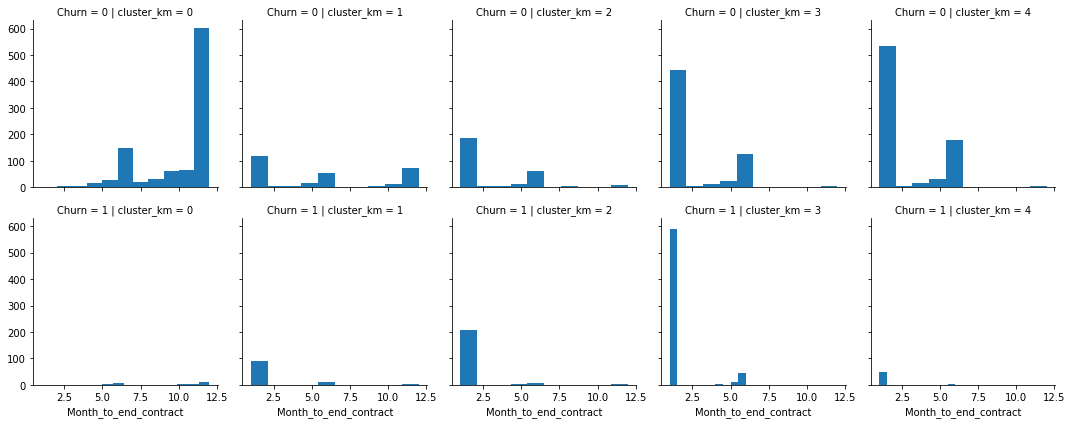

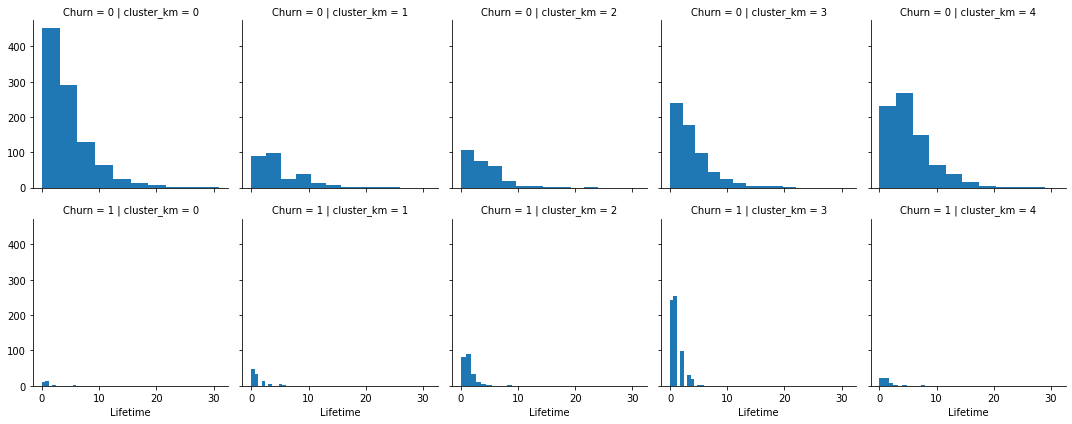

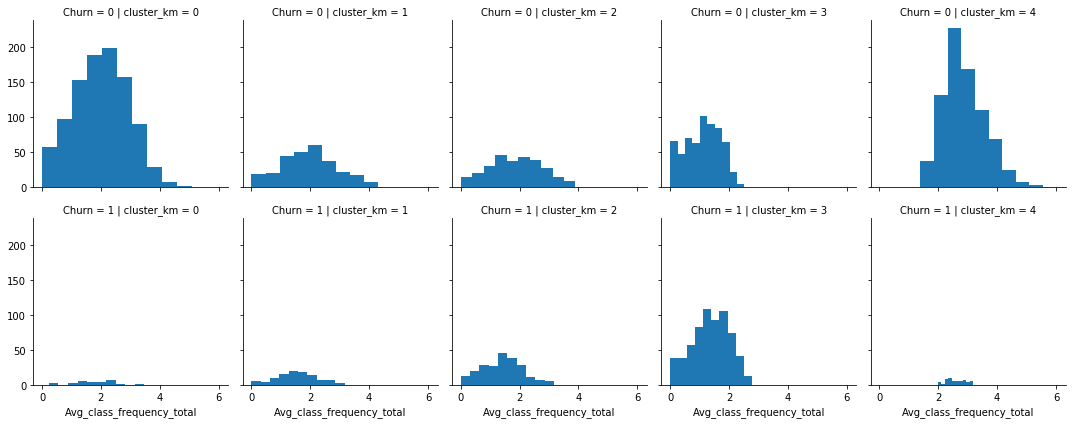

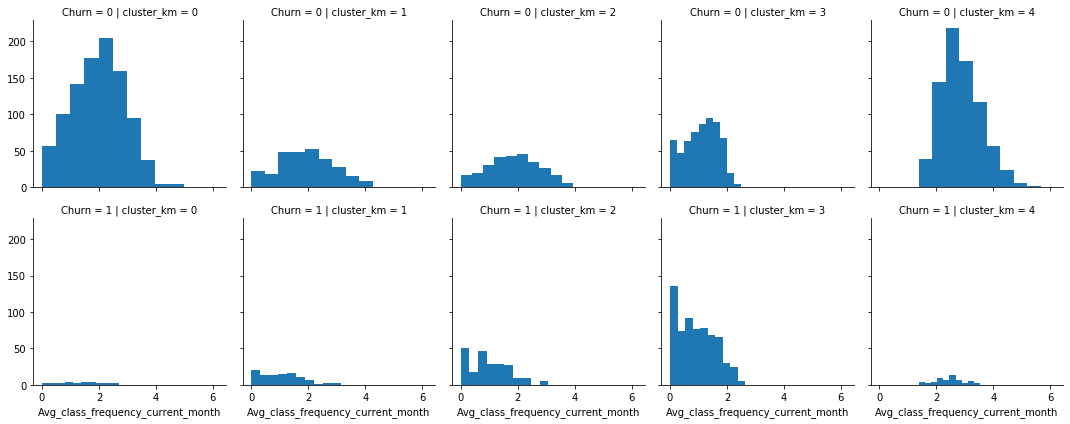

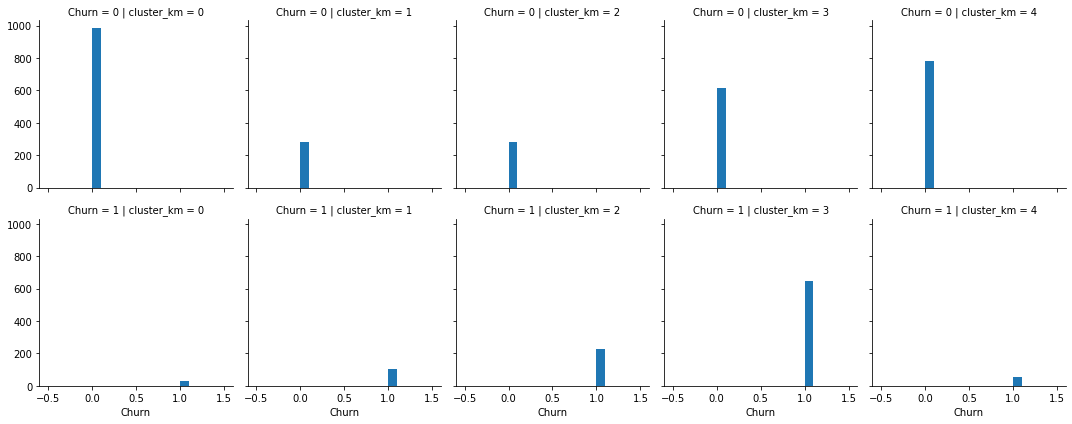

In [31]:
# построим гистограммы признаков для кластеров, кто ушел (отток) и тех, кто остался (не попал в отток)
for feature in df.drop('cluster_km', axis=1).columns:
    g = sns.FacetGrid(df, col='cluster_km', row='Churn')
    g = g.map(plt.hist, feature)

In [32]:
df_clusters = df.groupby(['cluster_km','Churn'])['Lifetime'].agg('count')

In [38]:
df_clusterts_churn_share = (df_clusters / df_clusters.groupby(level=0)
                            .sum()*100).round(2).reset_index()
df_clusterts_churn_share.columns = ['cluster_km', 'Churn', 'share']
df_clusterts_churn_share

,cluster_km,Churn,share
0,0,0,97.23
1,0,1,2.77
2,1,0,73.25
3,1,1,26.75
4,2,0,55.64
5,2,1,44.36
6,3,0,48.57
7,3,1,51.43
8,4,0,93.19
9,4,1,6.81


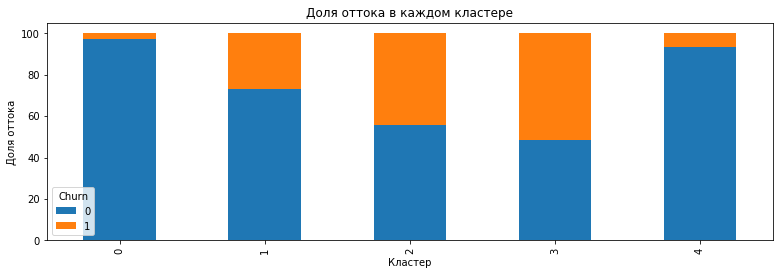

In [37]:
df_clusterts_churn_share.pivot('cluster_km','Churn','share')\
.plot(stacked=True, kind='bar', figsize=(13,4))
plt.title('Доля оттока в каждом кластере')
plt.xlabel('Кластер')
plt.ylabel('Доля оттока')
plt.show()

<b>Вывод</b>

Мы стандартизировали данные, построили матрицу расстояний на стандартизированных данных и вывели дедрограмму. На основе дедрограммы все клиенты делятся на кластеры и алгоритм предлагает по цветам выделить 4 основных кластера. Однако, величина одного из кластеров (розовый) составляет практически половину от всех пользователей. Таким образом разделили этот кластер на 2 и для алгоритма k-means выбрали значение кластеров, равное 5. 
Посмотрели на долю оттока в каждом кластере: меньше всего уходят в отток пользователи в кластерах 0 и 4, около половины пользователей из кластеров 2 и 3 уходят в отток.

### Шаг 5. Выводы и базовые рекомендации по работе с клиентами

После применения алгоритма кластеризации мы выделили 5 кластеров. В каждом кластере соотношение пользователей по полу практически одинаковое.
1. <b>Кластер 0</b> - пользователи живут или работают в районе фитнес центра, преимущественно сотрудники компании-партнера фитнес-центра, практически половина из них пришли по акции “приведи друга”, все они указали свой номер телефона, средняя длительность их текущего абонемента составляет почти 11 месяцев, средняя длительность до окончания абонемента составляет около 10 месяцев, средний возраст около 30 лет, склонны тратить деньги на дополнительные услуги фитнес-центра, среднее время с момента обращения в фитнес зал составляет 4,7 месяца. 
2. <b>Кластер 1</b> - пользователи живут или работают в районе фитнес центра, все они не указали свой номер телефона, средняя длительность их абонемента составляет 4,7 месяца, до окончания абонемента - 4,5 месяца. В основном ходят не более 2 раз в неделю
3. <b>Кластер 2</b> - все эти пользователи не живут и не работают в районе фитнес-центра, практически никто из них не пришел по акции “приведи друга”, они все указали свой номер телефона, средняя длительность их абонемента составляет 2,35 месяца, они реже склонны посещать групповые занятия, средний возраст составляет 28,4 лет, средняя длительность до окончания абонемента составляет 2,2 месяца.
4. <b>Кластер 3</b> - все пользователи живут или работают в районе фитнес-центра, мало кто из них является сотрудником компании-партнера, они все указали свой номер телефона, средняя длительность их абонемента составляет около 2 месяцев, средний возраст 28,2 лет, они меньше всего тратят на дополнительные услуги фитнес-центра, средняя длительность до окончания контракта - 2,4 месяца, всего в среднем они посещали фитнес-центр 1,2 раза в неделю, но за последний месяц этот показатель упал до 1 раза в неделю.
5. <b>Кластер 4</b> - большинство живет или работает в районе фитнес-центра, практически все указали свой номер телефона, средняя длительность абонемента составляет 2,7 месяца, средний возраст 30,1 лет, они больше всего склонны тратить деньги на дополнительные услуги фитнес-центра, они чаще всего занимаются в фитнес-центре (всего - 2,8 раз в неделю и за последний месяц этот показатель не упал).

Таким образом получили следующее:
1. реже всего уходят в отток пользователи в возрасте около 30 лет, которые пришли по акции "приведи друга", являются сотрудниками компании-партнера, приобретают длительные абонементы и занимаются 2 раза в неделю и более. Или пользователи в возрасте около 30 лет, которые склонны тратить в фитнес-центре больше всего денег на дополнительные услуги, которые посещают фитнес-центр более 2,8 раз в неделю.
2. Чаще всего уходят в отток пользователи в возрасте 28 лет, которые приобретают краткосрочные абонементы, не склонны тратить деньги на дополнительные услуги фитнес-центра, за последний месяц частота их посещений значительно падает.
3. В части рекомендаций по стратегии взаимодействия с клиентами и их удержания предлагается следующее:
<ul><li>с учетом того, что пользователи, которые уходят в отток указывают свой номер телефона, можно попробовать смс-рассылку с напоминанием посетить тренировку сегодня;</li>
    <li>на этапе приобретения пользователем абонемента рассказывать об основных преимуществах абонемента на более длительный период, рассмотреть возможность предложения пользователю рассрочки;</li>
    <li>активно рекламировать групповые тренировки и рассказывать об их преимуществах (регулярные групповые занятия больше мотивируют к результату тренировок);</li>
    <li>связаться с клиентом и узнать, по какой причине он стал ходить реже в фитнес-центр, в случае если заболел, предложить временную заморозку абонемента.</li></ul>